In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=2,
    root="../datasets/arda/04_21_full/",
    partial=0.8
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 2),
    output_dim=(partitions.future_frames, 256, 256, 1), 
    batch_size=16, 
    n_channels=1, 
    shuffle=True,
    buffer_size = 1e3,
    buffer_memory = 100
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0 

100%|██████████| 38/38 [00:05<00:00,  6.93it/s]


In [5]:
X.shape

(38, 16, 6, 256, 256, 2)

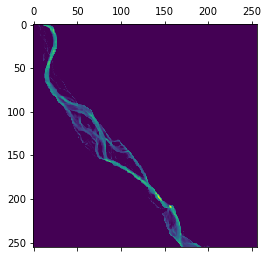

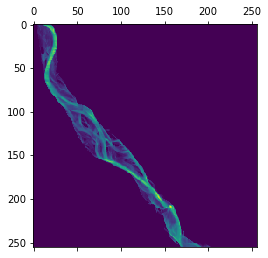

In [6]:
i = 5
plt.matshow(X[0, i, 0, :, :, 0])
plt.matshow(Y[0, i, 1, :, :, 0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
sc_img = StandardScaler() # image
sc_btm = StandardScaler() # image

for sample in X_train:
    for batch in sample:
        for frame in batch:
            sc_img.partial_fit(frame[:,:,0])
            #sc_btm.partial_fit(frame[:,:,2])

In [9]:
for s, sample in enumerate(X_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_train[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_train ready")        

for s, sample in enumerate(X_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_test[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_test transformed")
            
for s, sample in enumerate(y_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])

print("y_train transformed")

for s, sample in enumerate(y_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            
print("y_test transformed")

X_train ready
X_test transformed
y_train transformed
y_test transformed


In [10]:
X_test.shape

(8, 16, 6, 256, 256, 2)

### Model

In [11]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [12]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [13]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, (3, 3, 3), stride, padding=1)
        self.c2 = nn.Conv3d(filters, filters, (3, 3, 3), padding=1)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            residual = self.bn(residual)
            
        return self.activation(residual + y)


In [14]:
class ResTransBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride):
        super(ResTransBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.ConvTranspose3d(in_filters, filters, (3, 3, 3), stride)
        self.c2 = nn.ConvTranspose3d(filters, filters, (3, 3, 3))
        self.c3 = nn.ConvTranspose3d(in_filters, filters, (3,3,3), stride)
        
        self.bn = nn.BatchNorm3d(1000)

    def forward(self, x,):
        
        residual = x
        print(residual.shape)
        
        y = self.c1(x)

        y = self.b
        y = self.activation(y)
        y = self.c2(y)
        # batchnorm here

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            # batchnorm here
            
        print(y.shape)
        print(residual.shape)
            
        return self.activation(residual + y)


In [15]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels, past_frames, future_frames):
        super(Autoencoder, self).__init__()
        

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 64, (3,3,3), stride=2, padding=1),
            nn.AvgPool3d((2,2,2)),
            
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),
            ResNetBlock(in_filters = 64, filters = 64, stride = 2),

            nn.Conv3d(64, 128, (1,1,1)),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),
            ResNetBlock(in_filters = 128, filters = 128, stride = 2),

            nn.Conv3d(128, 256, (1,1,1)),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),
            ResNetBlock(in_filters = 256, filters = 256, stride = 2),
            
            
            nn.Conv3d(256, 512, (1,1,1)),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            ResNetBlock(in_filters = 512, filters = 512, stride = 2),
            
            
            nn.ConvTranspose3d(512, 512, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(512, 512, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(512, 256, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=256),
            
            nn.ConvTranspose3d(256, 256, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(256, 256, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(256, 128, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=128),
            
            nn.ConvTranspose3d(128, 128, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(128, 128, (1,2,2), stride=(1,2,2)),
            nn.ConvTranspose3d(128, 64, (2,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=64),
            
            nn.ConvTranspose3d(64, 64, (1,1,1), stride=(1,1,1)),
            nn.BatchNorm3d(num_features=64),
            
            nn.ConvTranspose3d(64, 1, (1,2,2), stride=(1,2,2)),
            
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [16]:
net = Autoencoder(2, 4, 4).to(device)
net(th.Tensor(np.random.random((16, 2, 4, 256, 256))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 64, 2, 128, 128
AvgPool3d           16, 64, 1, 64, 64
ResNetBlock         16, 64, 1, 32, 32
ResNetBlock         16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 8, 8
Conv3d              16, 128, 1, 8, 8
ResNetBlock         16, 128, 1, 4, 4
ResNetBlock         16, 128, 1, 2, 2
ResNetBlock         16, 128, 1, 1, 1
Conv3d              16, 256, 1, 1, 1
ResNetBlock         16, 256, 1, 1, 1
ResNetBlock         16, 256, 1, 1, 1
ResNetBlock         16, 256, 1, 1, 1
Conv3d              16, 512, 1, 1, 1
ResNetBlock         16, 512, 1, 1, 1
ResNetBlock         16, 512, 1, 1, 1
ResNetBlock         16, 512, 1, 1, 1
ConvTranspose3d     16, 512, 1, 2, 2
ConvTranspose3d     16, 512, 1, 4, 4
ConvTranspose3d     16, 256, 1, 8, 8
BatchNorm3d         16, 256, 1, 8, 8
ConvTranspose3d     16, 256, 1, 16, 16
ConvTranspose3d     16, 256, 1, 32, 32
ConvTranspose3d     16, 128, 1, 64, 64
BatchNorm3d         16, 128, 1, 64, 64
ConvTransp

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 7.93 GiB total capacity; 5.15 GiB already allocated; 1.93 GiB free; 5.17 GiB reserved in total by PyTorch)

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=10e-3)

In [ ]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [ ]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [ ]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [ ]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [ ]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [ ]:
losses = []
errors = []
test_errors = []

In [ ]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):
        
        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())
        
        if epoch % 5 == 0:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f' %
                  (epoch + 1, i + 1, train_err, test_err))
    
        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

In [ ]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass

In [ ]:
i = np.random.randint(len(X_test))
i

In [ ]:
outputs = net(X_test[i])

In [ ]:
for frame in y_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

In [ ]:
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))